<a href="https://colab.research.google.com/github/hammaad2002/RHM_FYP/blob/main/TCN_Model_on_Turkey_Wind_Farm_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
%%capture
!git clone https://github.com/alphaameer007/RHM_FYP

In [10]:
!pip install keras-tcn --no-dependencies 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
from tcn import TCN
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [12]:
df=pd.read_csv('/content/RHM_FYP/TurkeyWindFarm.csv')
df

,time,LV ActivePower (kW),Wind Speed (m/s),wind energy,Wind Direction (°)
0,1/1/2018 0:00,380.047791,5.311336,416.328908,259.994904
1,1/1/2018 0:10,453.769196,5.672167,519.917511,268.641113
2,1/1/2018 0:20,306.376587,5.216037,390.900016,272.564789
3,1/1/2018 0:30,419.645904,5.659674,516.127569,271.258087
4,1/1/2018 0:40,380.650696,5.577941,491.702972,265.674286
...,...,...,...,...,...
52555,12/31/2018 23:10,2963.980957,11.404030,3397.190793,80.502724
52556,12/31/2018 23:20,1684.353027,7.332648,1173.055771,84.062599
52557,12/31/2018 23:30,2201.106934,8.435358,1788.284755,84.742500
52558,12/31/2018 23:40,2515.694092,9.421366,2418.382503,84.297913


In [13]:
df.drop('time', inplace=True, axis=1)

In [14]:
df

,LV ActivePower (kW),Wind Speed (m/s),wind energy,Wind Direction (°)
0,380.047791,5.311336,416.328908,259.994904
1,453.769196,5.672167,519.917511,268.641113
2,306.376587,5.216037,390.900016,272.564789
3,419.645904,5.659674,516.127569,271.258087
4,380.650696,5.577941,491.702972,265.674286
...,...,...,...,...
52555,2963.980957,11.404030,3397.190793,80.502724
52556,1684.353027,7.332648,1173.055771,84.062599
52557,2201.106934,8.435358,1788.284755,84.742500
52558,2515.694092,9.421366,2418.382503,84.297913


In [15]:
max_values = df.max()              #normalizing data in between range [0,1]
df = df.div(max_values) 

In [16]:
df

,LV ActivePower (kW),Wind Speed (m/s),wind energy,Wind Direction (°)
0,0.105022,0.210717,0.115647,0.722213
1,0.125394,0.225032,0.144422,0.746230
2,0.084664,0.206936,0.108583,0.757129
3,0.115965,0.224537,0.143369,0.753500
4,0.105189,0.221294,0.136584,0.737989
...,...,...,...,...
52555,0.819066,0.452433,0.943664,0.223620
52556,0.465454,0.290909,0.325849,0.233509
52557,0.608253,0.334657,0.496746,0.235397
52558,0.695186,0.373775,0.671773,0.234162


In [17]:
#switching columns to make LV activePower (kW) last column so that it will be easy
# to prepare training and test datasets
cols = df.columns.tolist()
cols[0], cols[3] = cols[3], cols[0]
df = df[cols]

In [18]:
df

,Wind Direction (°),Wind Speed (m/s),wind energy,LV ActivePower (kW)
0,0.722213,0.210717,0.115647,0.105022
1,0.746230,0.225032,0.144422,0.125394
2,0.757129,0.206936,0.108583,0.084664
3,0.753500,0.224537,0.143369,0.115965
4,0.737989,0.221294,0.136584,0.105189
...,...,...,...,...
52555,0.223620,0.452433,0.943664,0.819066
52556,0.233509,0.290909,0.325849,0.465454
52557,0.235397,0.334657,0.496746,0.608253
52558,0.234162,0.373775,0.671773,0.695186


In [19]:
target=df['LV ActivePower (kW)']
target.shape

(52560,)

In [20]:
# Calculate the number of readings per day
readings_per_day = 144

#n = number of day
n = 3

# Calculate the sequence length (n days in readings)
sequence_length = readings_per_day * n

# Set the lookback window to be the same as the sequence length
lookback_window = sequence_length

# Convert the data to a NumPy array
df = df.values

x, y = [], []
for i in range(lookback_window, len(df)):
    x.append(df[i - lookback_window:i, :])
    y.append(df[i, -1])
x = np.array(x)
y = np.array(y)

In [21]:
print(x.shape)
print(y.shape)

(52128, 432, 4)
(52128,)


In [22]:
# Calculate the number of test samples (last 3 days of the year)
num_test_samples = readings_per_day * 3

# Split the data into training and test sets
x_train = x[:-num_test_samples]
y_train = y[:-num_test_samples]
x_test = x[-num_test_samples:]
y_test = y[-num_test_samples:]

In [23]:
x_train[lookback_window-1]

array([[0.5493698 , 0.60997117, 1.        , 0.95625377],
       [0.54131557, 0.72062099, 1.        , 0.99583008],
       [0.54306224, 0.72051505, 1.        , 0.9957137 ],
       ...,
       [0.16005037, 0.32161255, 0.44211176, 0.37089142],
       [0.15487882, 0.32176385, 0.44272998, 0.37636131],
       [0.14924783, 0.2971684 , 0.34806015, 0.27876553]])

In [24]:
y_train[0]

0.9958300752292879


       array([[0.5493698 , 0.60997117, 1.        , 0.95625377],

              [0.54131557, 0.72062099, 1.        , 0.99583008], <--- This 2nd sample will be predicted by the model that is stored as ground truth of first sample which is y_train[0]. 
       

In [25]:
model = keras.models.Sequential([
    TCN(input_shape=(lookback_window, 4), 
        kernel_size=10,
        nb_filters=32,
        dilations=[1, 2, 4, 8, 16],
        padding='causal',
        activation='relu',
        return_sequences=False,
        nb_stacks=4,
        use_skip_connections=False,
        use_batch_norm=False
        ),
    keras.layers.Dense(1)
])
model.summary()
model.compile('adam', 'mae',metrics=keras.metrics.MeanAbsolutePercentageError())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn (TCN)                   (None, 32)                402080    
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 402,113
Trainable params: 402,113
Non-trainable params: 0
_________________________________________________________________


In [26]:
print('Train...')
history = model.fit(x_train, y_train,
                    epochs=50,
                    verbose=1)

Train...
Epoch 1/50
1616/1616 [==============================] - 67s 31ms/step - loss: 6.7914 - mean_absolute_percentage_error: 86589.0156
Epoch 2/50
1616/1616 [==============================] - 50s 31ms/step - loss: 0.1204 - mean_absolute_percentage_error: 12796.6211
Epoch 3/50
1616/1616 [==============================] - 48s 30ms/step - loss: 0.0799 - mean_absolute_percentage_error: 6090.2563
Epoch 4/50
1616/1616 [==============================] - 48s 30ms/step - loss: 0.0639 - mean_absolute_percentage_error: 6038.9858
Epoch 5/50
1616/1616 [==============================] - 49s 30ms/step - loss: 0.0557 - mean_absolute_percentage_error: 4098.5566
Epoch 6/50
1616/1616 [==============================] - 48s 30ms/step - loss: 0.0491 - mean_absolute_percentage_error: 2703.6821
Epoch 7/50
1616/1616 [==============================] - 48s 30ms/step - loss: 0.0464 - mean_absolute_percentage_error: 2151.3760
Epoch 8/50
1616/1616 [==============================] - 48s 30ms/step - loss: 0.0417 -

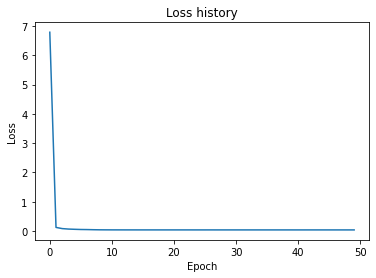

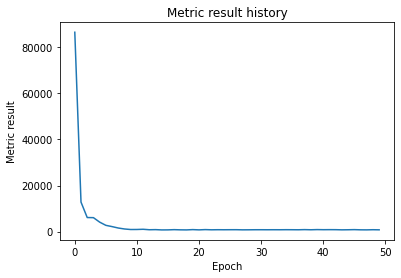

In [27]:
import matplotlib.pyplot as plt

# Extract the history of loss and metric result from the history object
loss_history = history.history['loss']
mape_history = history.history['mean_absolute_percentage_error']

# Plot the history of loss
plt.plot(loss_history)
plt.title('Loss history')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Plot the history of metric result
plt.plot(mape_history)
plt.title('Metric result history')
plt.xlabel('Epoch')
plt.ylabel('Metric result')
plt.show()


In [28]:
p = model.predict(x_test)

14/14 [==============================] - 1s 15ms/step


In [29]:
print(x_test.shape)
print(y_test.shape)
print(p.shape)

(432, 432, 4)
(432,)
(432, 1)


14/14 [==============================] - 0s 13ms/step


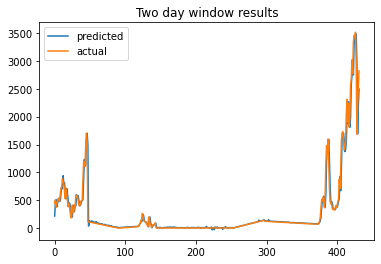

In [30]:
p = model.predict(x_test)
plt.plot(p*max_values[0]) #denormalizing prediction back
plt.plot(y_test*max_values[0]) #denormalizing original data back
plt.title('Two day window results')
plt.legend(['predicted', 'actual'])
plt.show()